## Tools
-> Pandas https://pandas.pydata.org/

-> Numpy http://www.numpy.org/

In [1]:
import pandas as pd
import numpy as np

## Models
Models are imported from a file `models.py`.


#### Models based on ODE (using odeint from scipy.integrate)
`ThermalBuffer` is a 3 meshes constant volume model of a stratified thermal storage 

`HeatPump` is a dynamic model based on a ratio of the theoretical COP of Carnot for heat pumps

#### Simple models
`Profile` is a model that can interpolate any time value from a given profile

`Hysteresis` is a simple hysteresis model that return a boolean

#### Methods
`dtok` transforms °C into K

`ktod` transforms K into °C

`t_out_from_m_dot_and_p` compute the dT given a mass flow and a heating power and return the output temperature based on the input temperature

`m_dot_from_p_and_t_in_and_t_set` compute a mass flow to ensure a given output temperature based on heating power and an input temperature

In [2]:
from models import ThermalBuffer, HeatPump, Profile, Hysteresis
from models import dtok, ktod, t_out_from_m_dot_and_p, m_dot_from_p_and_t_in_and_t_set

## Data

Creation of random synthetic consumption profiles (in kW) with Numpy and Pandas 

In [3]:
data = np.random.uniform(low=10.0, high=25.0, size=(24*365, 10))
rng = pd.date_range('1/1/2011', periods=24*365, freq='H')

profiles = pd.DataFrame(data, columns=[x for x in "abcdefghij"], index=rng)
profiles.head()

,a,b,c,d,e,f,g,h,i,j
2011-01-01 00:00:00,14.183941,11.334936,15.425050,13.545328,19.810715,10.621584,20.717103,11.646009,19.403296,11.883995
2011-01-01 01:00:00,15.271794,16.005331,19.229002,14.915164,20.118161,16.505280,14.393892,10.161436,13.180257,19.198734
2011-01-01 02:00:00,11.238085,24.505609,11.869965,18.568278,15.650237,20.087263,13.130815,12.599151,18.682703,14.931911
2011-01-01 03:00:00,15.133262,12.120397,13.021430,14.603620,13.262669,10.974183,19.213859,15.622213,11.416257,14.543646
2011-01-01 04:00:00,12.153719,22.815269,17.009957,20.257136,18.575237,12.127416,14.377041,14.632947,22.418199,12.062531


## Full model

#### Schema of the full model
![figure](./figures/model_AEE-Intec.svg)

#### Parameters
`m_dot_pri` is the massflow rate of the primary side, between the heat pump and the thermal storage

`t_set_ret_sec` is the set point temperature for return of the consumer on the secondary side

In [4]:
m_dot_pri = 0.15  # kg/s

t_set_ret_sec = 40.0

In [5]:
hp = HeatPump(25.0, dtok(80.0), dtok(25.0))
hp.io = True

In [6]:
tb = ThermalBuffer(ex_surf=0.5, mesh_h=2.0/3)
tb.t_snk = dtok(t_set_ret_sec)

In [7]:
hy = Hysteresis(x_min=0.25, x_max=0.75)
pr = Profile(profiles["a"])

#### Full model algorithm

STEPS:

1. Hysteresis
2. Heat pump
3. Thermal storage
4. Consumer (Profile)

In [8]:
def full_model_step(heat_pump, thermal_buffer, hysteresis, profile, step, unit="seconds"):
    hysteresis.x = thermal_buffer.soc
    hysteresis.make_step()
    
    heat_pump.io = hysteresis.y
    heat_pump.make_step(step, unit)
    
    if hysteresis.y == 1.0:
        thermal_buffer.m_dot_src = m_dot_pri
    else:
        thermal_buffer.m_dot_src = 0.0
        
    thermal_buffer.t_src = t_out_from_m_dot_and_p(thermal_buffer.t_bot, m_dot_pri, heat_pump.p_sink)
    heat_pump.t_cond = thermal_buffer.t_src 
    
    thermal_buffer.m_dot_snk = m_dot_from_p_and_t_in_and_t_set(profile.value, thermal_buffer.t_top, t_set_ret_sec)
    thermal_buffer.make_step(step, unit)
    
    profile.make_step(step, unit)

In [9]:
end = 12*24*2
results = np.array([[0.0, 0.0, 0.0, 0.0]] * end)
start = tb.time

for i in range(end):
    results[i] = [
        round(tb.soc, 2), 
        round(ktod(tb.t_top), 1), 
        round(ktod(tb.t_mid), 1), 
        round(ktod(tb.t_bot), 1)
    ]
    full_model_step(hp, tb, hy, pr, 5, "minutes")

## Results

In [10]:
rng = pd.date_range(start=start, freq="2Min", periods=len(results)) 
df = pd.DataFrame(results.tolist(), columns=["SoC_%", "T_top", "T_mid", "T_bot"], index=rng)
df.head()

,SoC_%,T_top,T_mid,T_bot
2000-01-01 00:00:00,0.50,80.0,60.0,40.0
2000-01-01 00:02:00,0.50,79.8,59.8,40.0
2000-01-01 00:04:00,0.49,79.6,59.6,40.0
2000-01-01 00:06:00,0.49,79.4,59.4,40.0
2000-01-01 00:08:00,0.49,79.2,59.2,40.0


In [11]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


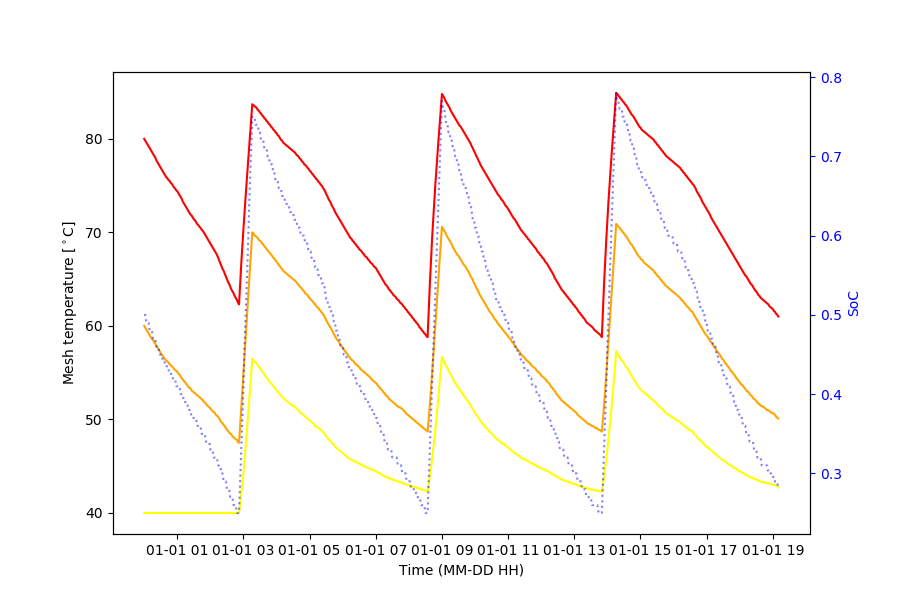

In [12]:
%matplotlib notebook

fig, ax1 = plt.subplots(figsize=(9,6))

ax1.plot(df.index, df.T_top, color="red")
ax1.plot(df.index, df.T_mid, color="orange")
ax1.plot(df.index, df.T_bot, color="yellow")

ax1.set_xlabel("Time (MM-DD HH)")
ax1.set_ylabel("Mesh temperature [$^\circ$C]")

ax2 = ax1.twinx()
ax2.plot(df.index, df["SoC_%"], ':b', alpha=0.5)
ax2.set_ylabel("SoC", color='b')
ax2.tick_params('y', colors='b')